In [121]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ipa_uk import ipa
from scipy.stats import pearsonr
from tqdm.auto import tqdm
import re

### 1. Corpus analysis

In [122]:
corpus = pd.read_csv('../data/corpus/ukr_news_2023_1M-words.txt', 
                     sep='\t', 
                     header=None, 
                     index_col=0)
corpus.columns = ['word', 'count']
# lower case
corpus['word'] = corpus['word'].str.lower()
# join identical words and sum their counts
corpus = corpus.groupby('word', as_index=False).sum()

In [123]:
# only get words that do not contain non-alphabetic characters
corpus = corpus[corpus['word'].str.isalpha()]
# should contain only ukrainian 
corpus = corpus[corpus['word'].str.match(r'^[А-ЩЬЮЯҐЄІЇа-щьюяґєії]+$')]

In [124]:
corpus['count'].sum()

2171696

In [125]:
# convert counts into frequencies
corpus['frequency'] = corpus['count'] / corpus['count'].sum()

In [126]:
slovotvir = pd.read_csv('../data/words_translations_cleaned.csv')

In [127]:
# pearson correlation between log rating and length
slovotvir['log_rating'] = np.log(slovotvir['rating'], where=(slovotvir['rating'] != 0))

slovotvir.query('rating > 0')['log_rating'].corr(slovotvir.query('rating > 0')['translation_len'], method='pearson')
# Calculate Pearson correlation and p-value
correlation, p_value = pearsonr(slovotvir.query('rating > 0')['log_rating'], slovotvir.query('rating > 0')['translation_len'])

# Print the results
print(f"Correlation: {correlation}")
print(f"P-value: {p_value.round(100)}")

Correlation: -0.1258421986582534
P-value: 0.0


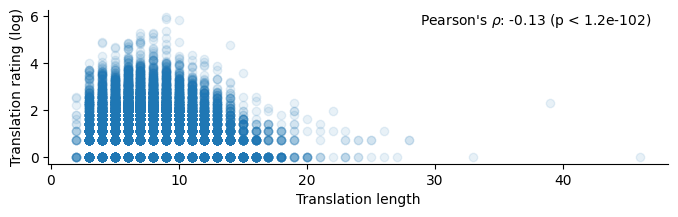

In [142]:
# plot this relationship

plt.figure(figsize=(8, 2))
plt.scatter(slovotvir.query('rating > 0')['translation_len'], 
            slovotvir.query('rating > 0')['log_rating'], alpha=0.1,
            color='tab:blue')
plt.gca().set_rasterized(True)
# add the perason correlation with p-value
plt.text(0.6, 0.9, fr"Pearson's $\rho$: {correlation.round(2)} (p < {p_value:.1e})", 
         transform=plt.gca().transAxes)
plt.xlabel('Translation length')
plt.ylabel('Translation rating (log)')
sns.despine()
plt.savefig('../figures/Figure_s6.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [129]:
# # # get top-100 most liked translations
# top_100 = slovotvir.sort_values('rating', ascending=False).head(100)[['word_body', 'translation_body']]

In [130]:
# get top-100 most liked translations and corresponding words
top_100 = slovotvir.sort_values('rating', ascending=False)[['word_body', 'translation_body']]

In [131]:
words = top_100.word_body.unique()
# for each word, extract the translations and store them in a list with their rank (i.e. index in the list based on ranking)
translations = []

for word in words:
    translations.append(slovotvir[slovotvir['word_body'] == word].sort_values('rating', ascending=False)['translation_body'].values)

In [132]:
# create a dataframe from translations with corresponding words and rank (i.e. index in the list based on ranking)

translations = pd.DataFrame(translations, index=words).stack().reset_index()
translations.columns = ['word', 'rank', 'translation']

In [133]:
# add rating from the original dataset by matching translation_body
translations = translations.merge(slovotvir[['translation_body', 'rating']], 
                                  left_on='translation', right_on='translation_body', how='left')

In [134]:
translations

,word,rank,translation,translation_body,rating
0,дедлайн,0,речене́ць,речене́ць,392.0
1,дедлайн,0,речене́ць,речене́ць,3.0
2,дедлайн,1,крайняк,крайняк,47.0
3,дедлайн,2,часоріз,часоріз,44.0
4,дедлайн,2,часоріз,часоріз,0.0
...,...,...,...,...,...
72691,андеррайтер,0,передпла́тник,передпла́тник,0.0
72692,десант,0,повст,повст,0.0
72693,десант,1,повстав,повстав,0.0
72694,десант,2,повстаття́,повстаття́,0.0


In [135]:
# for each translation, get the frequency of the translation in the corpus
translations['frequency'] = translations['translation'].map(corpus.set_index('word')['frequency'])
translations['count'] = translations['translation'].map(corpus.set_index('word')['count'])

In [136]:
translations.head(5)

,word,rank,translation,translation_body,rating,frequency,count
0,дедлайн,0,речене́ць,речене́ць,392.0,NaN,NaN
1,дедлайн,0,речене́ць,речене́ць,3.0,NaN,NaN
2,дедлайн,1,крайняк,крайняк,47.0,NaN,NaN
3,дедлайн,2,часоріз,часоріз,44.0,NaN,NaN
4,дедлайн,2,часоріз,часоріз,0.0,NaN,NaN


In [137]:
translations.dropna(subset=['frequency'], inplace=True)

In [266]:
translations.shape

(28881, 7)

In [267]:
median_count = translations['count'].median()
min_count = translations['count'].min()
max_count = translations['count'].max()

print(f"Median: {median_count}, Min: {min_count}, Max: {max_count}")

Median: 10.0, Min: 1.0, Max: 152.0


### 2. Characters vs sounds

In [103]:
words = pd.read_csv('../data/ukwiki-2022-08-30.txt', sep=' ', header=None)
words.columns = ['word', 'count']
words.dropna(inplace=True)
# lower case
words['word'] = words['word'].str.lower()
# join identical words and sum their counts
words = words.groupby('word', as_index=False).sum()
# remove non-alphabetic words
words = words[words['word'].str.isalpha()]
# should contain only ukrainian 
words = words[words['word'].str.match(r'^[А-ЩЬЮЯҐЄІЇа-щьюяґєії]+$')]
# remove words that are simplu repeated letters
words = words[~words['word'].str.match(r'^([а-щьюяґєії])\1+$')]
# count above 100
words = words[words['count'] > 100]
words.head()

,word,count
139456,а,1061770
139591,аалто,119
139602,аанг,144
139614,аарау,139
139619,ааре,139


In [109]:
words.shape

(119197, 2)

In [106]:
w_l = []
p_l = []

for w in tqdm(words['word']):
    w_l.append(len(w))
    p_l.append(len(ipa(w)))

  0%|          | 0/119197 [00:00<?, ?it/s]

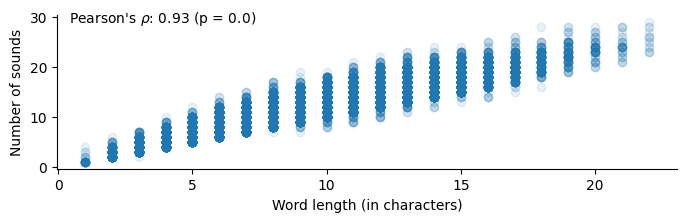

In [119]:
# plot pl vs wl

plt.figure(figsize=(8, 2))
plt.scatter(w_l, p_l, alpha=0.1, color='tab:blue')
# rasterise the scatter
plt.gca().set_rasterized(True)
# add pearson correlation
correlation, p_value = pearsonr(w_l, p_l)
p_value = round(p_value, 0)
plt.text(0.02, .95, fr"Pearson's $\rho$: {correlation.round(2)} (p = {p_value})", 
         transform=plt.gca().transAxes)
plt.xlabel('Word length (in characters)')
plt.ylabel('Number of sounds')
sns.despine()
plt.savefig('../figures/Figure_s5.pdf', dpi=300, bbox_inches='tight')
plt.show()